# WireframeClassifier

## Data PreProcessing

**Data Augmentation**

In [ ]:
from PIL import Image
import os

dir_path = '../wires/wirever copy'  

if not os.path.exists(dir_path):
    print(f"Directory '{dir_path}' does not exist.")
    exit()  

rotation_angles = [90, 180, 270]
flip_modes = ['LR', 'UD']

def augment_image(image_path):
    # Open the image
    image = Image.open(image_path)

    for angle in rotation_angles:
        rotated_image = image.rotate(angle)
        rotated_image.save(image_path[:-4] + f'_rotated_{angle}.png')

    for mode in flip_modes:
        flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT if mode == 'LR' else Image.FLIP_TOP_BOTTOM)
        flipped_image.save(image_path[:-4] + f'_flipped_{mode}.png')

for subdir in os.listdir(dir_path):
    subdir_path = os.path.join(dir_path, subdir)
    if os.path.isdir(subdir_path):  
        for file_name in os.listdir(subdir_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_path = os.path.join(subdir_path, file_name)
                augment_image(image_path)


**Remove Image Background**

In [ ]:
import numpy as np
from rembg import remove
from PIL import Image
img=Image.open(r'../images/1_flipped_UD.png')
img
print('remv')
out=remove(img)
out.save('out.png')

**Data Cleaning**

In [ ]:
import os
from rembg import remove
from PIL import Image

input_dir = '../wires/wirever copy'  
output_dir = '../wires/wire2ver'  

if not os.path.exists(input_dir):
    print(f"Input directory '{input_dir}' does not exist.")
    exit()  

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def segment_image(image_path, output_path):
    image = Image.open(image_path)

    segmented_image = remove(image)
 
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    segmented_image.save(output_path)

def segment_images_in_directory(input_directory, output_directory):
    for subdir, _, files in os.walk(input_directory):
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                input_image_path = os.path.join(subdir, file_name)
                relative_path = os.path.relpath(input_image_path, input_directory)
                output_image_path = os.path.join(output_directory, relative_path[:-4] + '_segmented.png')
                segment_image(input_image_path, output_image_path)

segment_images_in_directory(input_dir, output_dir)


**Data Segmentation**

In [ ]:
import os
from sklearn.model_selection import train_test_split
import shutil

input_dir = '../wires/wire2ver' 
output_dir = '../wires/wire3prm'  
for split in ['train', 'test', 'validate']:
    for class_dir in os.listdir(input_dir):
        os.makedirs(os.path.join(output_dir, split, class_dir), exist_ok=True)

image_paths = []
classes = []
for class_dir in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_dir)
    for file_name in os.listdir(class_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            image_paths.append(os.path.join(class_path, file_name))
            classes.append(class_dir)

train_paths, test_validate_paths, train_classes, test_validate_classes = train_test_split(
    image_paths, classes, test_size=0.2, random_state=42)
test_paths, validate_paths, test_classes, validate_classes = train_test_split(
    test_validate_paths, test_validate_classes, test_size=0.5, random_state=42)

for paths, class_labels, split in zip([train_paths, test_paths, validate_paths],
                                      [train_classes, test_classes, validate_classes],
                                      ['train', 'test', 'validate']):
    for path, class_label in zip(paths, class_labels):
        file_name = os.path.basename(path)
        dest_dir = os.path.join(output_dir, split, class_label)
        shutil.copy(path, os.path.join(dest_dir, file_name))

**Data Counting**

In [30]:
import os

def count_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.gif')): # Ajoutez les extensions d'image supplémentaires au besoin
                total_images += 1
    return total_images

# Chemin du dossier à explorer
dataset_directory = "../wires/wire3prm"

# Appel de la fonction pour compter les images
num_images = count_images(dataset_directory)

# Affichage du nombre d'images
print("Nombre total d'images dans le dossier et ses sous-dossiers :", num_images)

Nombre total d'images dans le dossier et ses sous-dossiers : 358


## Model Creation

**Model Training and Evaluation**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6  # Number of classes in your dataset
TRAIN_DATA_DIR = '../wires/wire3prm/train'
TEST_DATA_DIR = '../wires/wire3prm/test'
VALIDATION_DATA_DIR = '../wires/wire3prm/validate'

# Preprocess the data with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Load the VGG16 model pretrained on ImageNet without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

# Fine-tune the VGG16 base by setting trainable layers
for layer in base_model.layers[:-4]:
    layer.trainable = True

# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
validation_steps = max(1, validation_generator.samples // BATCH_SIZE)

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


2024-04-27 16:53:49.660001: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 16:53:49.980102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 16:53:49.980144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 16:53:50.033898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 16:53:50.160521: I tensorflow/core/platform/cpu_feature_guar

Found 286 images belonging to 6 classes.
Found 36 images belonging to 6 classes.
Found 36 images belonging to 6 classes.


2024-04-27 16:53:52.945547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 16:53:53.122399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 16:53:53.122554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/10


2024-04-27 16:53:55.184833: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-27 16:53:55.386016: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-27 16:53:55.885220: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-27 16:53:56.173781: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-27 16:53:56.706774: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

8/8 [==============================] - 73s 6s/step - loss: 1.9861 - accuracy: 0.2126 - val_loss: 1.3742 - val_accuracy: 0.4688
Epoch 2/10
8/8 [==============================] - 8s 941ms/step - loss: 1.5735 - accuracy: 0.3740 - val_loss: 1.1546 - val_accuracy: 0.5938
Epoch 3/10
8/8 [==============================] - 8s 949ms/step - loss: 1.3099 - accuracy: 0.5236 - val_loss: 0.8220 - val_accuracy: 0.8125
Epoch 4/10
8/8 [==============================] - 8s 945ms/step - loss: 0.9917 - accuracy: 0.6496 - val_loss: 0.5217 - val_accuracy: 0.9062
Epoch 5/10
8/8 [==============================] - 8s 949ms/step - loss: 0.7303 - accuracy: 0.7598 - val_loss: 0.3041 - val_accuracy: 0.9375
Epoch 6/10
8/8 [==============================] - 8s 948ms/step - loss: 0.5336 - accuracy: 0.8386 - val_loss: 0.1943 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 8s 951ms/step - loss: 0.4361 - accuracy: 0.8425 - val_loss: 0.1218 - val_accuracy: 0.9688
Epoch 8/10
8/8 [=================

**Model Testing and Validation**

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True classes for the test set
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Generate and print confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:")
print(class_report)

2/2 [==============================] - 1s 305ms/step
Confusion Matrix:
[[2 0 0 1 1 4]
 [0 0 0 0 2 1]
 [2 1 0 0 1 0]
 [1 1 1 2 0 1]
 [2 1 1 1 2 1]
 [1 0 2 3 1 0]]

Classification Report:
                precision    recall  f1-score   support

        button       0.25      0.25      0.25         8
   imagecercle       0.00      0.00      0.00         3
imagerectangle       0.00      0.00      0.00         4
         input       0.29      0.33      0.31         6
          logo       0.29      0.25      0.27         8
          text       0.00      0.00      0.00         7

      accuracy                           0.17        36
     macro avg       0.14      0.14      0.14        36
  weighted avg       0.17      0.17      0.17        36



In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27563334 (105.15 MB)
Trainable params: 27563334 (105.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
for layer in model.layers:
    print(layer.name)

vgg16
flatten
dense
dropout
dense_1


In [29]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load the image you want to make predictions on
img_path = '/home/ss/work/dev/ai/ml/yof/wires/wire2ver/imagerectangle/2_segmented.png'  # Change this to the path of your image

# Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Make predictions
predictions = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class]

# Print the predicted class and confidence
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

1/1 [==============================] - 0s 19ms/step
Predicted class: 2
Confidence: 0.9972118735313416


## Visualisations

**Confusion Matrix Heatmap**

2/2 [==============================] - 0s 320ms/step


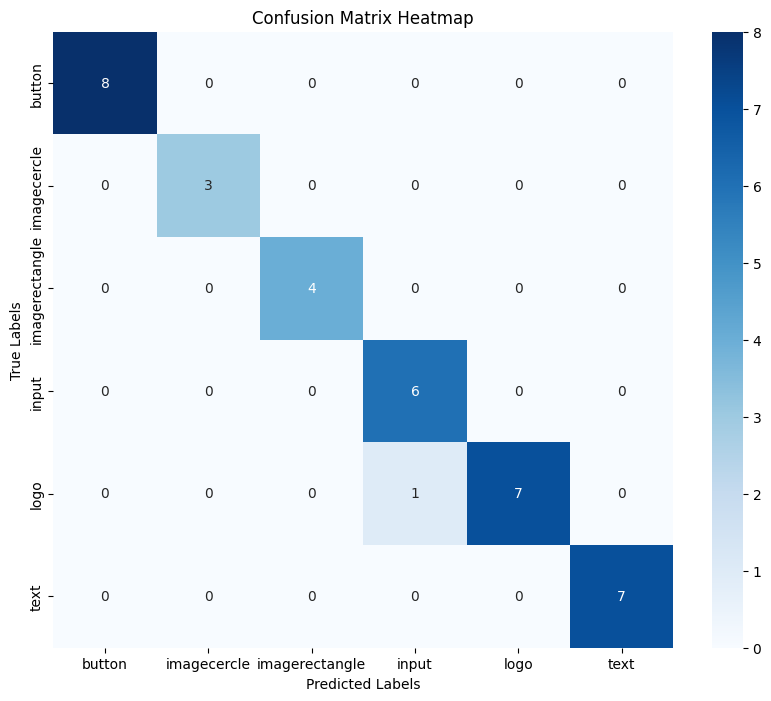

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       0.86      1.00      0.92         6
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         7

    accuracy                           0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.98      0.97      0.97        36



In [22]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU

from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer



# Vérifier les données de test
test_generator.reset()
test_images = []
test_labels = []

for i in range(len(test_generator)):
    images, labels = next(test_generator)
    test_images.extend(images)
    test_labels.extend(np.argmax(labels, axis=1))

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Prédire les classes pour l'ensemble de test
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(test_labels, y_pred)

# Visualiser la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculer et afficher le rapport de classification
print(classification_report(test_labels, y_pred))




**ROC Curve and AUC Value**

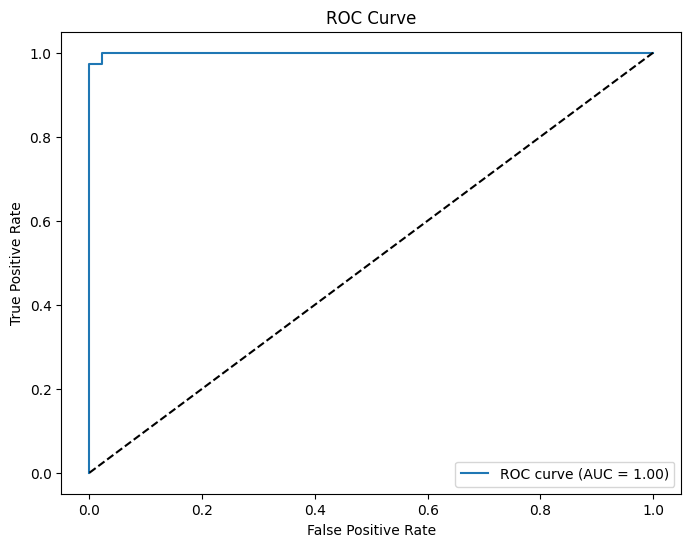

In [23]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Convert test labels to binary format
lb = LabelBinarizer()
test_labels_bin = lb.fit_transform(test_labels)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels_bin.ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


**Model Loss** 

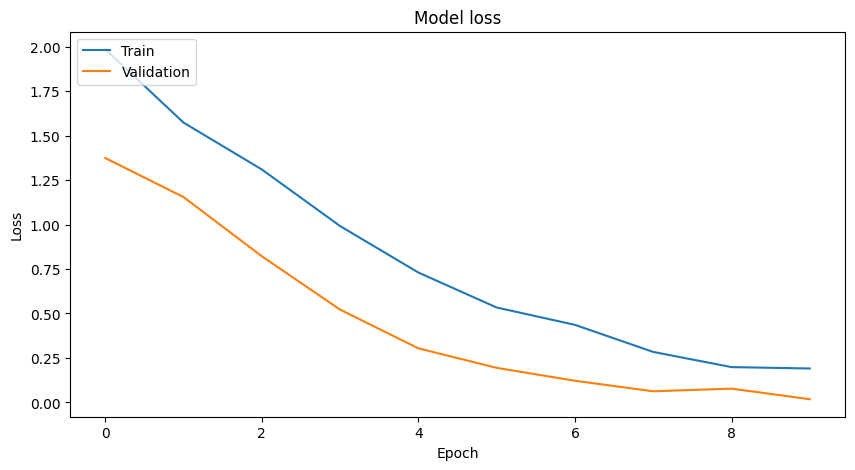

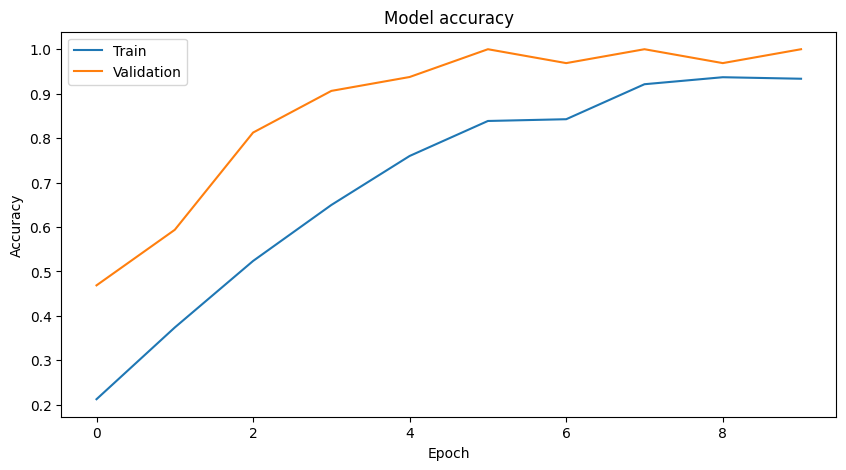

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')
plt.show()

**Model Accuracy**

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

**Misclassified Image with Prediction**

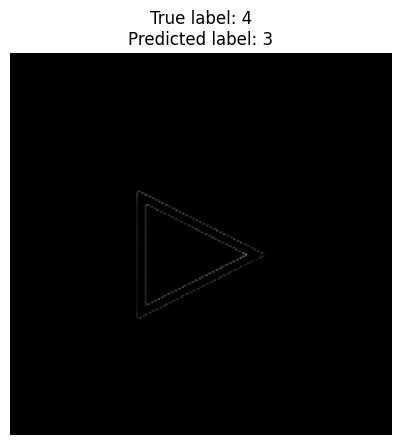

In [ ]:
misclassified_idx = np.where(y_pred != test_labels)[0]

# Plot misclassified images with their predictions
plt.figure(figsize=(20, 10))
for i, idx in enumerate(misclassified_idx[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f"True label: {test_labels[idx]}\nPredicted label: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('misclassified_examples.png')
plt.show()


**Histogram of Predicted Probabilities**

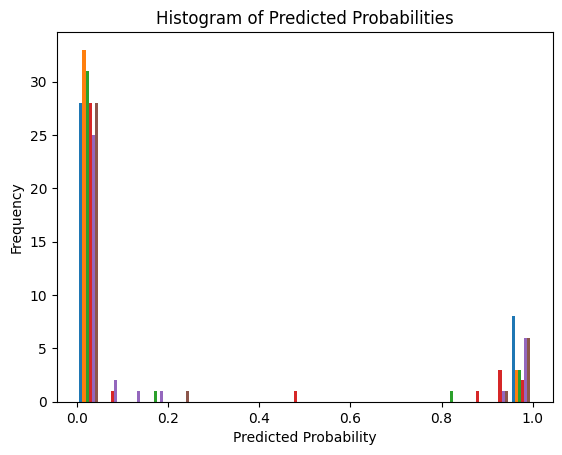

In [ ]:
# Plot histogram of predicted probabilities
plt.hist(predictions, bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.savefig('probability_histogram.png')
plt.show()
